<a href="https://colab.research.google.com/github/takoloco/covid19/blob/master/COVID_19_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec

import datetime
import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters

In [0]:
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'
df1 = pd.read_csv(url)

In [0]:
### MANUAL UPLOAD ###
#from google.colab import files
#uploaded = files.upload()
#import io
#df2 = pd.read_csv(io.BytesIO(uploaded['time_series_19-covid-Confirmed.csv']), header=0, parse_dates=True, squeeze=True)
# Dataset is now stored in a Pandas Dataframe

In [0]:
## CONSTANTS ##
US_START_DATE = '3/10/20'
FORMAT_DATE_SOURCE = '%m/%d/%y'
FORMAT_DATE_DISPLAY = '%m-%d'
NUM_CHARTS_IN_ROW = 2
CHART_WIDTH_DEFAULT = 8
CHART_HEIGHT_DEFAULT = 5

In [0]:
def set_ax_info(ax, title, ylabel, xlabel, format_display='%m-%d', legend_loc=2):
  ax.set_title(title)
  ax.set_ylabel(ylabel)
  ax.set_xlabel(xlabel)
  ax.xaxis_date()
  ax.xaxis.set_major_formatter(mdates.DateFormatter(format_display))
  ax.legend(loc=legend_loc)

def plot_data(df_list, titles, ylabels, xlabels, format_display=None, legend_loc=None, start_date=None, x_val_list=[]):
  row_num = len(df_list)//NUM_CHARTS_IN_ROW
  if row_num == 0 or len(df_list)%row_num != 0:
    row_num += 1

  fig = plt.figure(figsize=(CHART_WIDTH_DEFAULT*NUM_CHARTS_IN_ROW, CHART_HEIGHT_DEFAULT*row_num), constrained_layout=True)
  spec = gridspec.GridSpec(ncols=NUM_CHARTS_IN_ROW, nrows=row_num, figure=fig)

  subplots = []
  for i in range(len(df_list)):
    subplots.append(fig.add_subplot(spec[i//NUM_CHARTS_IN_ROW, i%NUM_CHARTS_IN_ROW]))

  if start_date:
    date_start_index = list(df_list[0].keys()).index(start_date)
  else:
    date_start_index = 0

  if not x_val_list:
    for df in df_list:
      x_val_list.append(list(map(lambda name: datetime.datetime.strptime(name, FORMAT_DATE_SOURCE), df.keys()[date_start_index:])))

  for index, df in enumerate(df_list):
    for row_num, row in df.iterrows():
      subplots[index].plot(x_val_list[index], row.values[date_start_index:], label=row_num)
      set_ax_info(subplots[index], titles[index], ylabels[index], xlabels[index])

In [0]:
states = ['California', 'Michigan', 'New York', 'Washington']
df_states = df1[df1['Province/State'].isin(states)]
df_states.set_index('Province/State', inplace=True)
df_states = df_states[df_states.columns[3:]]

In [0]:
# Merge Current State Population Numbers
population = {
    'state': ['California', 'Michigan', 'New York', 'Washington'],
    'population': [39.56 * 1000000, 9.996 * 1000000, 8.623 * 100000, 7.536 * 1000000]
}
df_population = pd.DataFrame.from_dict(population)

In [0]:
states_per_capita = []
for row_num, row in df_states.iterrows():
  states_per_capita.append(row/int((df_population['population'][df_population['state'] == row_num])))
df_states_per_capita = pd.DataFrame(states_per_capita)

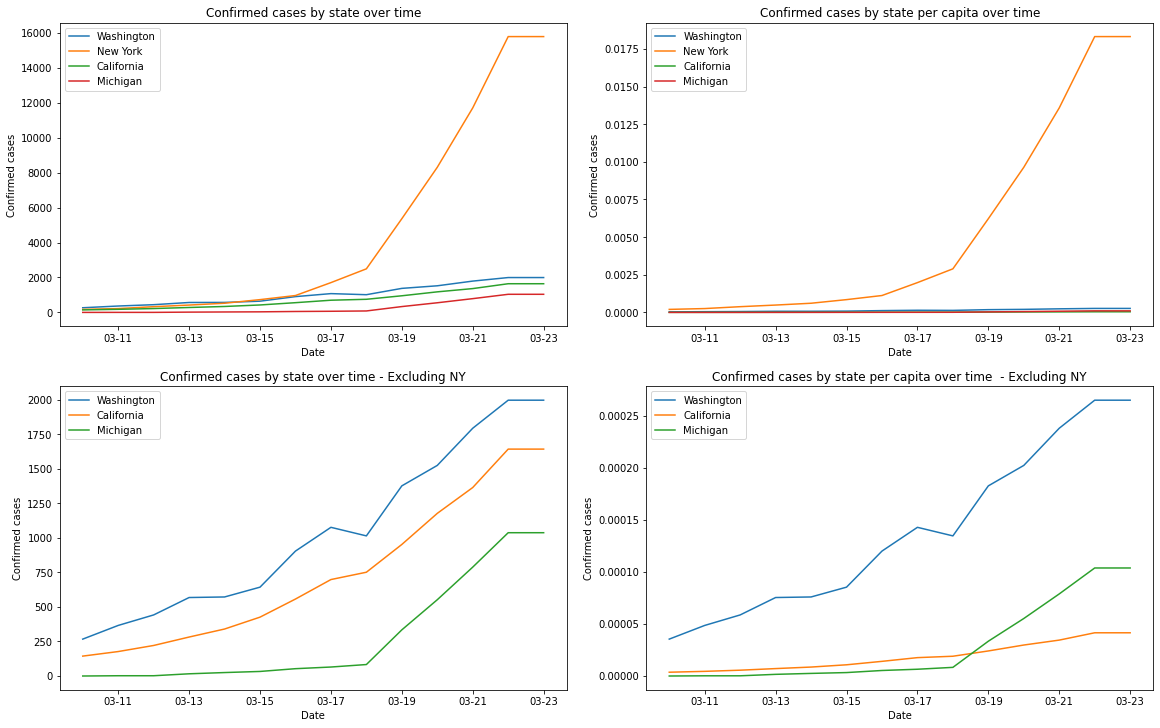

In [128]:
dfs = [df_states, df_states_per_capita, df_states.loc[df_states.index != 'New York'], df_states_per_capita.loc[df_states_per_capita.index != 'New York']]
titles = ['Confirmed cases by state over time', 'Confirmed cases by state per capita over time', 'Confirmed cases by state over time - Excluding NY', 'Confirmed cases by state per capita over time  - Excluding NY']
ylabels = ['Confirmed cases', 'Confirmed cases', 'Confirmed cases', 'Confirmed cases']
xlabels = ['Date', 'Date', 'Date', 'Date']

plot_data(dfs, titles, ylabels, xlabels, start_date=US_START_DATE)

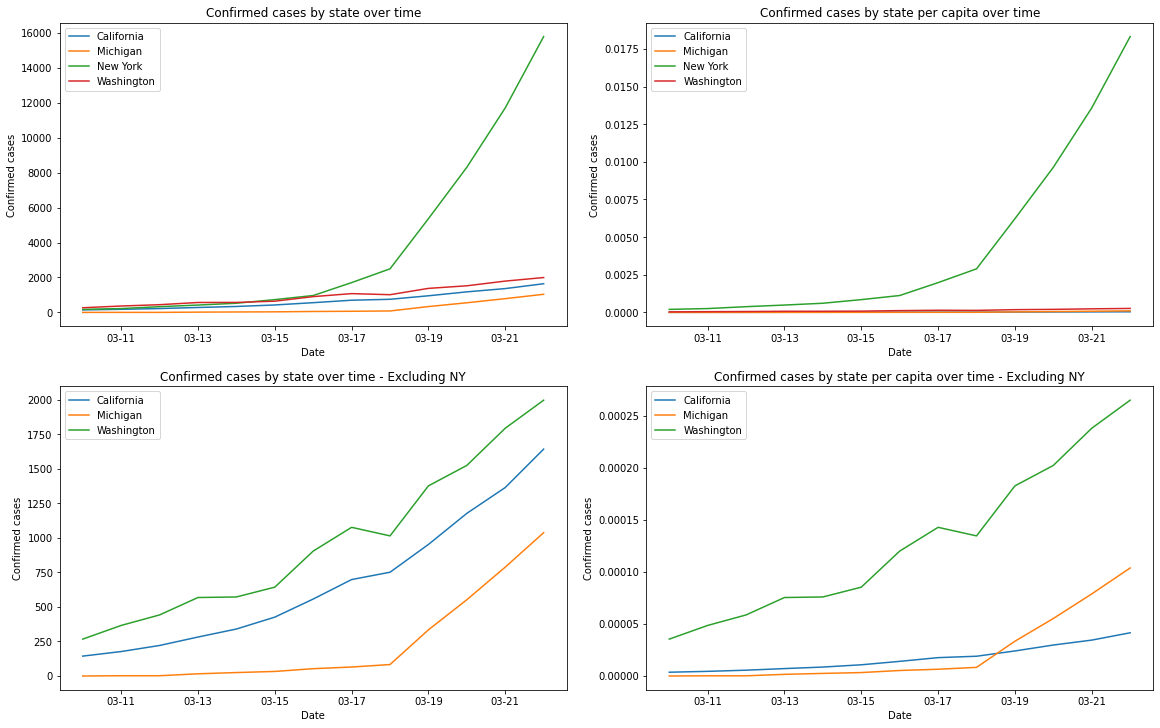

In [7]:
US_START_DATE = '3/10/20'
FORMAT_DATE_SOURCE = '%m/%d/%y'
FORMAT_DATE_DISPLAY = '%m-%d'

register_matplotlib_converters()

fig = plt.figure(figsize=(16, 10), constrained_layout=True)
spec = gridspec.GridSpec(ncols=2, nrows=2, figure=fig)
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[0, 1])
ax3 = fig.add_subplot(spec[1, 0])
ax4 = fig.add_subplot(spec[1, 1])

date_start_index = list(df_states_pop.keys()).index(US_START_DATE)
x_vals = list(map(lambda name: datetime.datetime.strptime(name, FORMAT_DATE_SOURCE), df_states_pop.keys()[date_start_index:]))

for row_num, row in df_states_pop.iterrows():
  ax1.plot(x_vals, row.values[date_start_index:], label=row_num)
  ax2.plot(x_vals, row.values[date_start_index:]/row[1], label=row_num)
  if row[0] != 'New York':
    ax3.plot(x_vals, row.values[date_start_index:], label=row_num)
    ax4.plot(x_vals, row.values[date_start_index:]/row[1], label=row_num)


x_date_format = mdates.DateFormatter(FORMAT_DATE_DISPLAY)

ax1.set_title('Confirmed cases by state over time')
ax1.set_ylabel('Confirmed cases')
ax1.set_xlabel('Date')
ax1.xaxis_date()
ax1.xaxis.set_major_formatter(x_date_format)
ax1.legend(loc=2)

ax2.set_title('Confirmed cases by state per capita over time')
ax2.set_ylabel('Confirmed cases')
ax2.set_xlabel('Date')
ax2.xaxis_date()
ax2.xaxis.set_major_formatter(x_date_format)
ax2.legend(loc=2)

ax3.set_title('Confirmed cases by state over time - Excluding NY')
ax3.set_ylabel('Confirmed cases')
ax3.set_xlabel('Date')
ax3.xaxis_date()
ax3.xaxis.set_major_formatter(x_date_format)
ax3.legend(loc=2)

ax4.set_title('Confirmed cases by state per capita over time - Excluding NY')
ax4.set_ylabel('Confirmed cases')
ax4.set_xlabel('Date')
ax4.xaxis_date()
ax4.xaxis.set_major_formatter(x_date_format)
ax4.legend(loc=2)

plt.show()

In [0]:
df_states_diffs = df_states_pop[df_states_pop.columns[5:]].diff(axis=1)
df_states_diffs = pd.merge(df_population, df_states_diffs, left_on='state', right_index=True)
df_states_diffs.set_index('state', inplace=True)

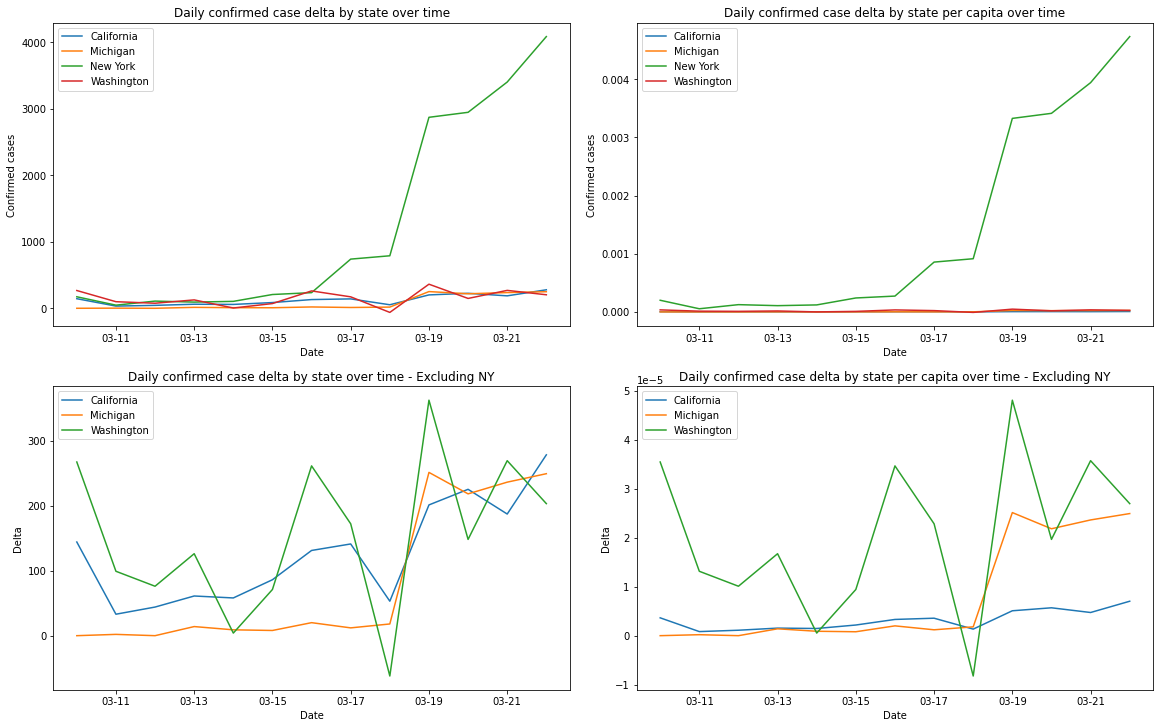

In [9]:
fig = plt.figure(figsize=(16, 10), constrained_layout=True)
spec = gridspec.GridSpec(ncols=2, nrows=2, figure=fig)
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[0, 1])
ax3 = fig.add_subplot(spec[1, 0])
ax4 = fig.add_subplot(spec[1, 1])

date_start_index = list(df_states_diffs.keys()).index(US_START_DATE)
x_vals = list(map(lambda name: datetime.datetime.strptime(name, FORMAT_DATE_SOURCE), df_states_diffs.keys()[date_start_index:]))

for row_num, row in df_states_diffs.iterrows():
  ax1.plot(x_vals, row.values[date_start_index:], label=row_num)
  ax2.plot(x_vals, row.values[date_start_index:]/row[0], label=row_num)
  if row_num != 'New York':
    ax3.plot(x_vals, row.values[date_start_index:], label=row_num)
    ax4.plot(x_vals, row.values[date_start_index:]/row[0], label=row_num)

x_date_format = mdates.DateFormatter(FORMAT_DATE_DISPLAY)

ax1.set_title('Daily confirmed case delta by state over time')
ax1.set_ylabel('Confirmed cases')
ax1.set_xlabel('Date')
ax1.xaxis_date()
ax1.xaxis.set_major_formatter(x_date_format)
ax1.legend(loc=2)

ax2.set_title('Daily confirmed case delta by state per capita over time')
ax2.set_ylabel('Confirmed cases')
ax2.set_xlabel('Date')
ax2.xaxis_date()
ax2.xaxis.set_major_formatter(x_date_format)
ax2.legend(loc=2)

ax3.set_title('Daily confirmed case delta by state over time - Excluding NY')
ax3.set_ylabel('Delta')
ax3.set_xlabel('Date')
ax3.xaxis_date()
ax3.xaxis.set_major_formatter(x_date_format)
ax3.legend(loc=2)

ax4.set_title('Daily confirmed case delta by state per capita over time - Excluding NY')
ax4.set_ylabel('Delta')
ax4.set_xlabel('Date')
ax4.xaxis_date()
ax4.xaxis.set_major_formatter(x_date_format)
ax4.legend(loc=2)

plt.show()

In [0]:
df_states_diffs_retroactive = df_states_diffs.diff(periods=-1, axis=1).multiply(-100)

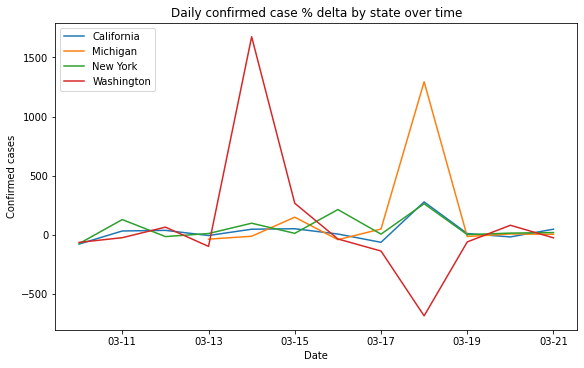

In [11]:
fig = plt.figure(figsize=(8, 5), constrained_layout=True)
spec = gridspec.GridSpec(ncols=1, nrows=1, figure=fig)
ax1 = fig.add_subplot(spec[0, 0])

date_start_index = list(df_states_diffs_retroactive.keys()).index(US_START_DATE)
x_vals = list(map(lambda name: datetime.datetime.strptime(name, FORMAT_DATE_SOURCE), df_states_diffs_retroactive.keys()[date_start_index:]))

for row_num, row in df_states_diffs_retroactive.iterrows():
  ax1.plot(x_vals, row.values[date_start_index:]/df_states_diffs[df_states_diffs.columns[date_start_index:]].loc[row_num], label=row_num)

x_date_format = mdates.DateFormatter(FORMAT_DATE_DISPLAY)

ax1.set_title('Daily confirmed case % delta by state over time')
ax1.set_ylabel('Confirmed cases')
ax1.set_xlabel('Date')
ax1.xaxis_date()
ax1.xaxis.set_major_formatter(x_date_format)
ax1.legend(loc=2)

plt.show()

In [0]:
def set_ax_info(ax, title, ylabel, xlabel, format_display='%m-%d', legend_loc=2):
  ax.set_title(title)
  ax.set_ylabel(ylabel)
  ax.set_xlabel(xlabel)
  ax.xaxis_date()
  ax.xaxis.set_major_formatter(mdates.DateFormatter(format_display))
  ax.legend(loc=legend_loc)

def plot_data(df_list, title, ylabel, xlabel, format_display=None, legend_loc=None, start_date=None, x_val_list=[]):
  row_num = len(df_list)//NUM_CHARTS_IN_ROW
  if row_num == 0 or len(df_list)%row_num != 0:
    row_num += 1

  fig = plt.figure(figsize=(CHART_WIDTH_DEFAULT*NUM_CHARTS_IN_ROW, CHART_HEIGHT_DEFAULT*row_num), constrained_layout=True)
  spec = gridspec.GridSpec(ncols=NUM_CHARTS_IN_ROW, nrows=row_num, figure=fig)

  subplots = []
  for i in range(len(df_list)):
    subplots.append(fig.add_subplot(spec[i//NUM_CHARTS_IN_ROW, i%NUM_CHARTS_IN_ROW]))

  if start_date:
    date_start_index = list(df_list[0].keys()).index(start_date)
  else:
    date_start_index = 0

  if not x_val_list:
    for df in df_list:
      x_val_list.append(list(map(lambda name: datetime.datetime.strptime(name, FORMAT_DATE_SOURCE), df.keys()[date_start_index:])))

  for index, df in enumerate(df_list):
    for row_num, row in df.iterrows():
      for subplot in subplots:
        subplot.plot(x_val_list[index], row.values[date_start_index:], label=row_num)
        set_ax_info(subplot, title, ylabel, xlabel)


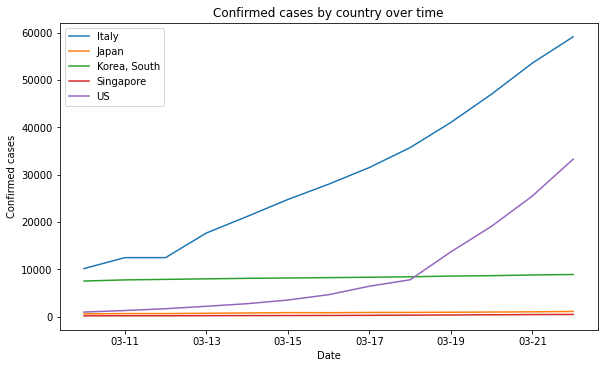

In [46]:
plot_data([df_countries], 'Confirmed cases by country over time', 'Confirmed cases', 'Date', start_date=US_START_DATE)

In [0]:
countries = ['Italy', 'Japan', 'Korea, South', 'Singapore', 'US']
df_countries = df1[df1['Country/Region'].isin(countries)].groupby('Country/Region').sum()
df_countries = df_countries[df_countries.columns[2:]]

In [0]:
df_countries_diffs = df_countries.diff(axis=1)
df_countries_diffs_retroactive = df_countries.diff(periods=-1, axis=1).multiply(-100)

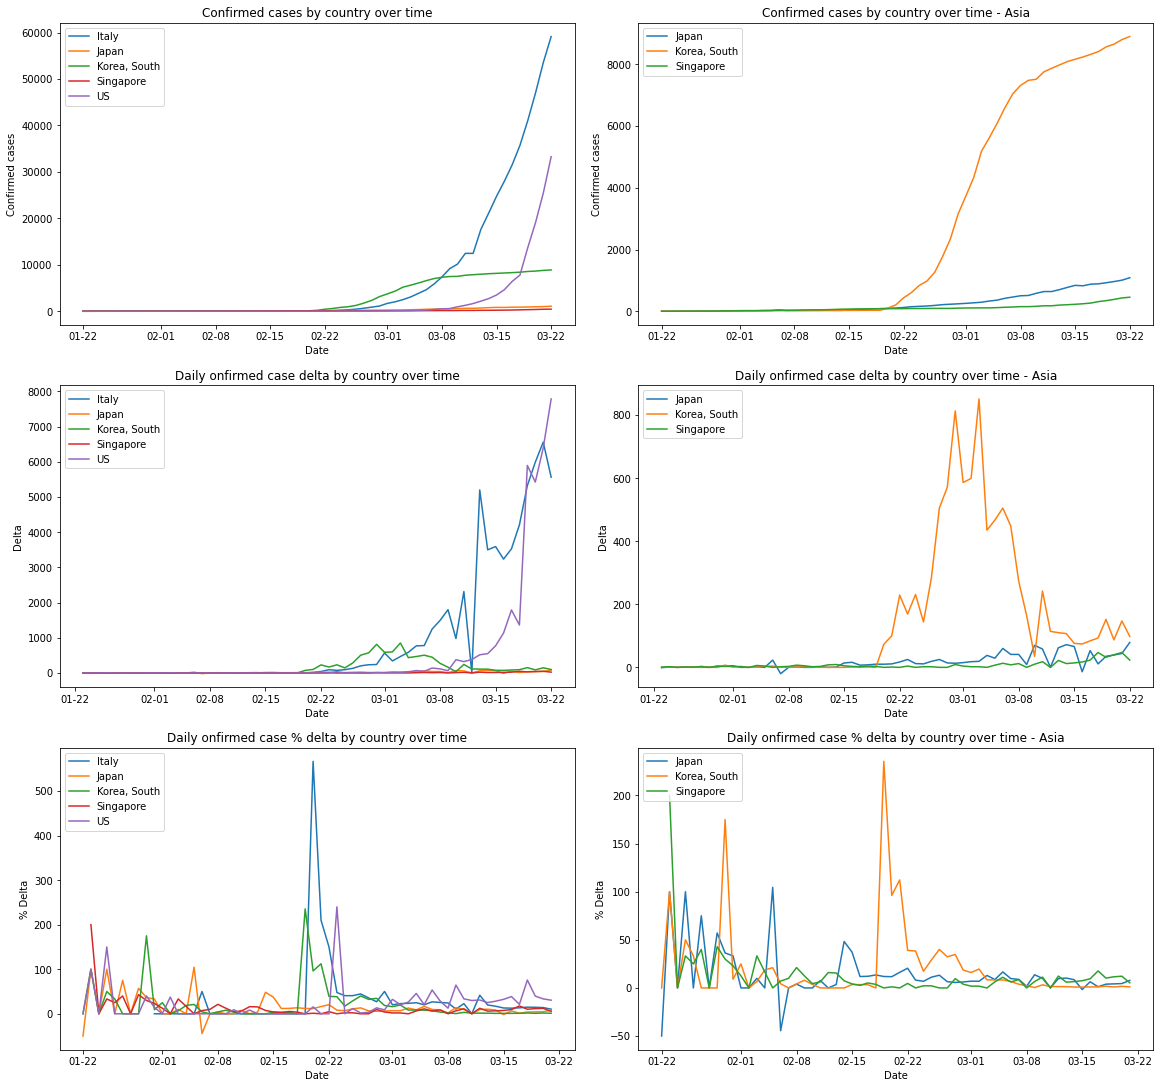

In [15]:
register_matplotlib_converters()

fig = plt.figure(figsize=(16, 15), constrained_layout=True)
spec = gridspec.GridSpec(ncols=2, nrows=3, figure=fig)
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[0, 1])
ax3 = fig.add_subplot(spec[1, 0])
ax4 = fig.add_subplot(spec[1, 1])
ax5 = fig.add_subplot(spec[2, 0])
ax6 = fig.add_subplot(spec[2, 1])

x_vals = list(map(lambda name: datetime.datetime.strptime(name, '%m/%d/%y'), df_countries.keys()))
x_date_format = mdates.DateFormatter('%m-%d')

for row_num, row in df_countries.iterrows():
  ax1.plot(x_vals, row.values, label=row_num)
  if row_num not in ['Italy', 'US']:
    ax2.plot(x_vals, row.values, label=row_num)

ax1.set_title('Confirmed cases by country over time')
ax1.set_ylabel('Confirmed cases')
ax1.set_xlabel('Date')
ax1.xaxis_date()
ax1.xaxis.set_major_formatter(x_date_format)
ax1.legend(loc=2)

ax2.set_title('Confirmed cases by country over time - Asia')
ax2.set_ylabel('Confirmed cases')
ax2.set_xlabel('Date')
ax2.xaxis_date()
ax2.xaxis.set_major_formatter(x_date_format)
ax2.legend(loc=2)

for row_num, row in df_countries_diffs.iterrows():
  ax3.plot(x_vals, row.values, label=row_num)
  if row_num not in ['Italy', 'US']:
    ax4.plot(x_vals, row.values, label=row_num)

ax3.set_title('Daily onfirmed case delta by country over time')
ax3.set_ylabel('Delta')
ax3.set_xlabel('Date')
ax3.xaxis_date()
ax3.xaxis.set_major_formatter(x_date_format)
ax3.legend(loc=2)

ax4.set_title('Daily onfirmed case delta by country over time - Asia')
ax4.set_ylabel('Delta')
ax4.set_xlabel('Date')
ax4.xaxis_date()
ax4.xaxis.set_major_formatter(x_date_format)
ax4.legend(loc=2)

for row_num, row in df_countries_diffs_retroactive.iterrows():
  ax5.plot(x_vals, row.values/df_countries.loc[row_num], label=row_num)
  if row_num not in ['Italy', 'US']:
    ax6.plot(x_vals, row.values/df_countries.loc[row_num], label=row_num)

ax5.set_title('Daily onfirmed case % delta by country over time')
ax5.set_ylabel('% Delta')
ax5.set_xlabel('Date')
ax5.xaxis_date()
ax5.xaxis.set_major_formatter(x_date_format)
ax5.legend(loc=2)

ax6.set_title('Daily onfirmed case % delta by country over time - Asia')
ax6.set_ylabel('% Delta')
ax6.set_xlabel('Date')
ax6.xaxis_date()
ax6.xaxis.set_major_formatter(x_date_format)
ax6.legend(loc=2)

plt.show()
